# Compressor analysis

## Database structure

The following analysis relies on data gathered in `compression.db` which has the following structure:

* **compressors**(*compressor*)

  This table stores the list of all compressors to be tested by the script, e.g. `('lz4',)`


* **options**(*compressor*, *options*)

  This table stores the list of all combinations of compressors and command line options to be tested by the script, e.g. `('lz4', '-9')`


* **results**(*machine*, *arch*, *compressor*, *options*, succeeded, elapsed, max_resident, ratio)

  This is the "main" table, storing the results of all compression runs. It is keyed by the machine's label, architecture, the compressor being tested, and its command line options. The non-key attributes are a boolean (0 or 1) indicating whether the test succeeded, the number of seconds elapsed during the test, the maximum resident memory used (in kilobytes), and the compression ratio achieved (a value > 0.0 and hopefully < 1)

## Data gathering

If you wish to add entries to the database, use the `gather.py` script in the repo. You will need some (preferably uncompressed) data to work with. I would suggest the uncompressed copy of the platform's initrd (as that's what this is ultimately all about) which can be obtained (on Ubuntu Pi images) like so:

```
$ zstdcat /boot/firmware/initrd.img > initrd.cpio
```

Then, to add rows for your machine to the database:

```
$ python3 gather.py --machine 'Pi 3B' initrd.cpio
Testing gzip -1
Testing gzip -2
...
```

You need to provide some label for your machine with the `--machine` option, which should be vaguely descriptive of the hardware you are running on. The machine's architecture will be queried with `dpkg`, and you will need all compressors that are to be tested, installed. Needless to say, tests should be run on an otherwise idle system.

The script will only run tests that have not yet been recorded in the database for the specific combination of machine, architecture, compressor, and options. In other words, if a run is interrupted for some reason, it can be carried on without repeating earlier tests (this is useful for forcibly skipping tests 

## Analysis

In [1]:
import sqlite3
import matplotlib.pyplot as plt
from html import escape
from IPython.core.display import HTML
%matplotlib inline

In [9]:
conn = sqlite3.connect('bikeshed.db')

In [10]:
def show_query(sql):
    cur = conn.execute(sql)
    columns = [r[0] for r in cur.description]
    rows = list(cur)
    cur.close()
    headers = "".join(
        f"<th>{escape(str(header).title())}</th>"
        for header in columns
    )
    data = "\n".join(
        f"<tr>{html_row}</tr>"
        for row in rows
        for html_row in ("".join(
            f"<td>{escape(str(cell))}</td>"
            for cell in row
        ),)
    )
    return f"""
<table>
<thead><tr>{headers}</tr></thead>
<tbody>{data}</tbody>
</table>"""

### Machines tested

In [8]:
HTML(show_query("""
SELECT DISTINCT machine, arch
FROM results
"""))

Machine,Arch
AMD Opteron,amd64
AMD Ryzen,amd64
Pi 4 8GB,arm64
Pi 4 8GB,armhf
Pi Zero 2,armhf


### Dangerous combinations

Show all compressor+option combinations that failed to produce a result

In [3]:
HTML(show_query("""
SELECT machine, arch, compressor, options
FROM results
WHERE succeeded = 0
"""))

Machine,Arch,Compressor,Options
Pi Zero 2,armhf,xz,-8
Pi Zero 2,armhf,xz,-9
Pi Zero 2,armhf,xz,-e -8
Pi Zero 2,armhf,xz,-e -9
Pi Zero 2,armhf,zstd,-T0 -14
Pi Zero 2,armhf,zstd,-T0 -15
Pi Zero 2,armhf,zstd,-T0 -19


### Silly combinations

Show all compressor+option combinations that took more than 20 seconds to produce a result

In [4]:
HTML(show_query("""
SELECT machine, compressor, options, elapsed
FROM results
WHERE elapsed > 20
ORDER BY elapsed DESC
"""))

Machine,Compressor,Options,Elapsed
Pi 4 8GB,xz,-e -9,311.71
Pi 4 8GB,xz,-e -8,288.21
Pi 4 8GB,xz,-e -7,274.09
Pi 4 8GB,xz,-e -6,256.3
Pi 4 8GB,xz,-e -4,239.38
Pi 4 8GB,xz,-e -5,237.94
Pi 4 8GB,xz,-9,237.6
Pi 4 8GB,xz,-e -2,226.93
Pi 4 8GB,xz,-e -3,224.09
Pi 4 8GB,xz,-8,221.13


In [5]:
compressors = [
    row[0]
    for row in conn.execute("SELECT compressor FROM compressors")
]
data = {
    compressor:
    list(conn.execute("""
        SELECT elapsed, ratio
        FROM results
        WHERE compressor = ?
        AND succeeded = 1
    """, (compressor,)))
    for compressor in compressors
}
data = {
    compressor: {
        'elapsed': [elapsed for elapsed, ratio in results],
        'ratio': [ratio for elapsed, ratio in results],
    }
    for compressor, results in data.items()
}

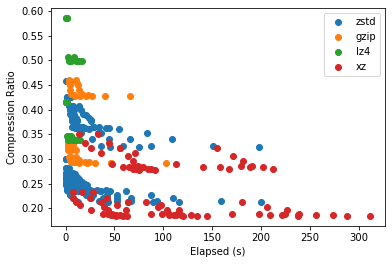

In [6]:
for compressor, results in data.items():
    plt.plot('elapsed', 'ratio', data=results,
             label=compressor, marker='o', linestyle='none')
plt.xlabel('Elapsed (s)')
plt.ylabel('Compression Ratio')
plt.legend()